In [7]:
%pip install numpy
%pip install scikit-learn
%pip install pandas
%pip install factor_analyzer
%pip install seaborn
%pip install nltk
%pip install gensim


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: C:\Users\Витя Кенг\PycharmProjects\NLP_LAB_DM23\venv\Scripts\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: C:\Users\Витя Кенг\PycharmProjects\NLP_LAB_DM23\venv\Scripts\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: C:\Users\Витя Кенг\PycharmProjects\NLP_LAB_DM23\venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: C:\Users\Витя Кенг\PycharmProjects\NLP_LAB_DM23\venv\Scripts\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[n

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
import itertools
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Витя
[nltk_data]     Кенг\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
df = pd.read_csv(f"train.csv")
df.dropna(subset=['Title', 'Description'], inplace=True)

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


In [6]:
print(df['Title'].describe())
print(df['Description'].describe())

count           120000
unique          114350
top       Transactions
freq                39
Name: Title, dtype: object
count                                                120000
unique                                               118723
top       With the economy slowly turning up, upgrading ...
freq                                                     15
Name: Description, dtype: object


In [24]:
import string
import re
from nltk.corpus import stopwords


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_trash(text):
    text = re.sub(r'[^\w\d\s]', '', text).strip()
    return re.sub(r'\s+', ' ', text).strip()

def remove_digits(text):
    return re.sub(r'\d', '', text).strip()

def lower(text):
    return text.lower()

def preprocess_df(data, functions):
    for column in data.columns:
        if str(data[column].dtype) != 'int64':
            data[column] = data[column].apply(lower)
            for function in functions:
                data[column] = data[column].apply(eval(function))

In [25]:
preprocessing_functions = ["remove_digits", "remove_trash", "remove_punctuation", "remove_stopwords"]
all_combinations = []
for i in range(1,len(preprocessing_functions)+1):
   all_combinations += list(itertools.combinations(preprocessing_functions,i))

In [28]:
for combination in all_combinations:
    for file in ["train", "test"]:
        df = pd.read_csv(f"{file}.csv")
        preprocess_df(df, combination)
        df.to_csv(f"{'_'.join(combination)}_{file}.csv", index=0)

In [29]:
all_filenames_combinations = [f"{'_'.join(combination)}_train.csv" for combination in all_combinations]
all_filenames_combinations += ["train.csv"]

In [56]:
def read_and_split(filename):
    data = pd.read_csv(filename)
    data.dropna(subset=['Title', 'Description', 'Class Index'], inplace=True)
    X = data['Title'] + ' ' + data['Description']
    y = data['Class Index']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [70]:
import numpy as np
from gensim.models import Word2Vec, FastText
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize

result = {}

def document_vector(doc, model):
    # Removing out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# Функция для трансформации текстов в средние векторы
def transform_with_word_embedding(X, model):
    return np.array([document_vector(text, model) for text in X])

for filename in all_filenames_combinations:
    X_train, X_test, X_val, y_train, y_test, y_val = read_and_split(filename)
    vectorizers = ["CountVectorizer", "TfidfVectorizer", "Word2Vec", "FastText", "GloVe"]

    # Загрузка или обучение моделей Word2Vec и FastText
    word2vec_model = Word2Vec(X_train, min_count=1)
    fasttext_model = FastText(X_train, min_count=1)

    for vectorizer_name in vectorizers:
        if not result.get(vectorizer_name):
            result[vectorizer_name] = {}

        if vectorizer_name in ["CountVectorizer", "TfidfVectorizer"]:
            vectorizer = eval(vectorizer_name)()
            X_train_vec = vectorizer.fit_transform(X_train)
            X_val_vec = vectorizer.transform(X_val)
            X_test_vec = vectorizer.transform(X_test)
        else:
            X_train_tokens = X_train.apply(word_tokenize)
            X_val_tokens = X_val.apply(word_tokenize)
            X_test_tokens = X_test.apply(word_tokenize)
            if vectorizer_name == "Word2Vec":
                X_train_vec = transform_with_word_embedding(X_train_tokens, word2vec_model)
                X_val_vec = transform_with_word_embedding(X_val_tokens, word2vec_model)
                X_test_vec = transform_with_word_embedding(X_test_tokens, word2vec_model)
            elif vectorizer_name == "FastText":
                X_train_vec = transform_with_word_embedding(X_train_tokens, fasttext_model)
                X_val_vec = transform_with_word_embedding(X_val_tokens, fasttext_model)
                X_test_vec = transform_with_word_embedding(X_test_tokens, fasttext_model)


        log_reg = LogisticRegression(random_state=42)
        log_reg.fit(X_train_vec, y_train)
        y_val_pred = log_reg.predict(X_val_vec)
        y_test_pred = log_reg.predict(X_test_vec)

        f1_score_mean = (f1_score(y_val, y_val_pred, average="weighted") +
                         f1_score(y_test, y_test_pred, average="weighted")) / 2
        result[vectorizer_name][filename] = f1_score_mean

print(result)


{'CountVectorizer': {'remove_digits_train.csv': 0.8977915696254546, 'remove_trash_train.csv': 0.8989472175578153, 'remove_punctuation_train.csv': 0.8997363568205075, 'remove_stopwords_train.csv': 0.9026993204539684, 'remove_digits_remove_trash_train.csv': 0.8996045788405713, 'remove_digits_remove_punctuation_train.csv': 0.9000533036932732, 'remove_digits_remove_stopwords_train.csv': 0.901817322121623, 'remove_trash_remove_punctuation_train.csv': 0.8997363568205075, 'remove_trash_remove_stopwords_train.csv': 0.9052599728333353, 'remove_punctuation_remove_stopwords_train.csv': 0.9050909676222479, 'remove_digits_remove_trash_remove_punctuation_train.csv': 0.9000533036932732, 'remove_digits_remove_trash_remove_stopwords_train.csv': 0.903520785274196, 'remove_digits_remove_punctuation_remove_stopwords_train.csv': 0.903368390278013, 'remove_trash_remove_punctuation_remove_stopwords_train.csv': 0.9050909676222479, 'remove_digits_remove_trash_remove_punctuation_remove_stopwords_train.csv': 0.9

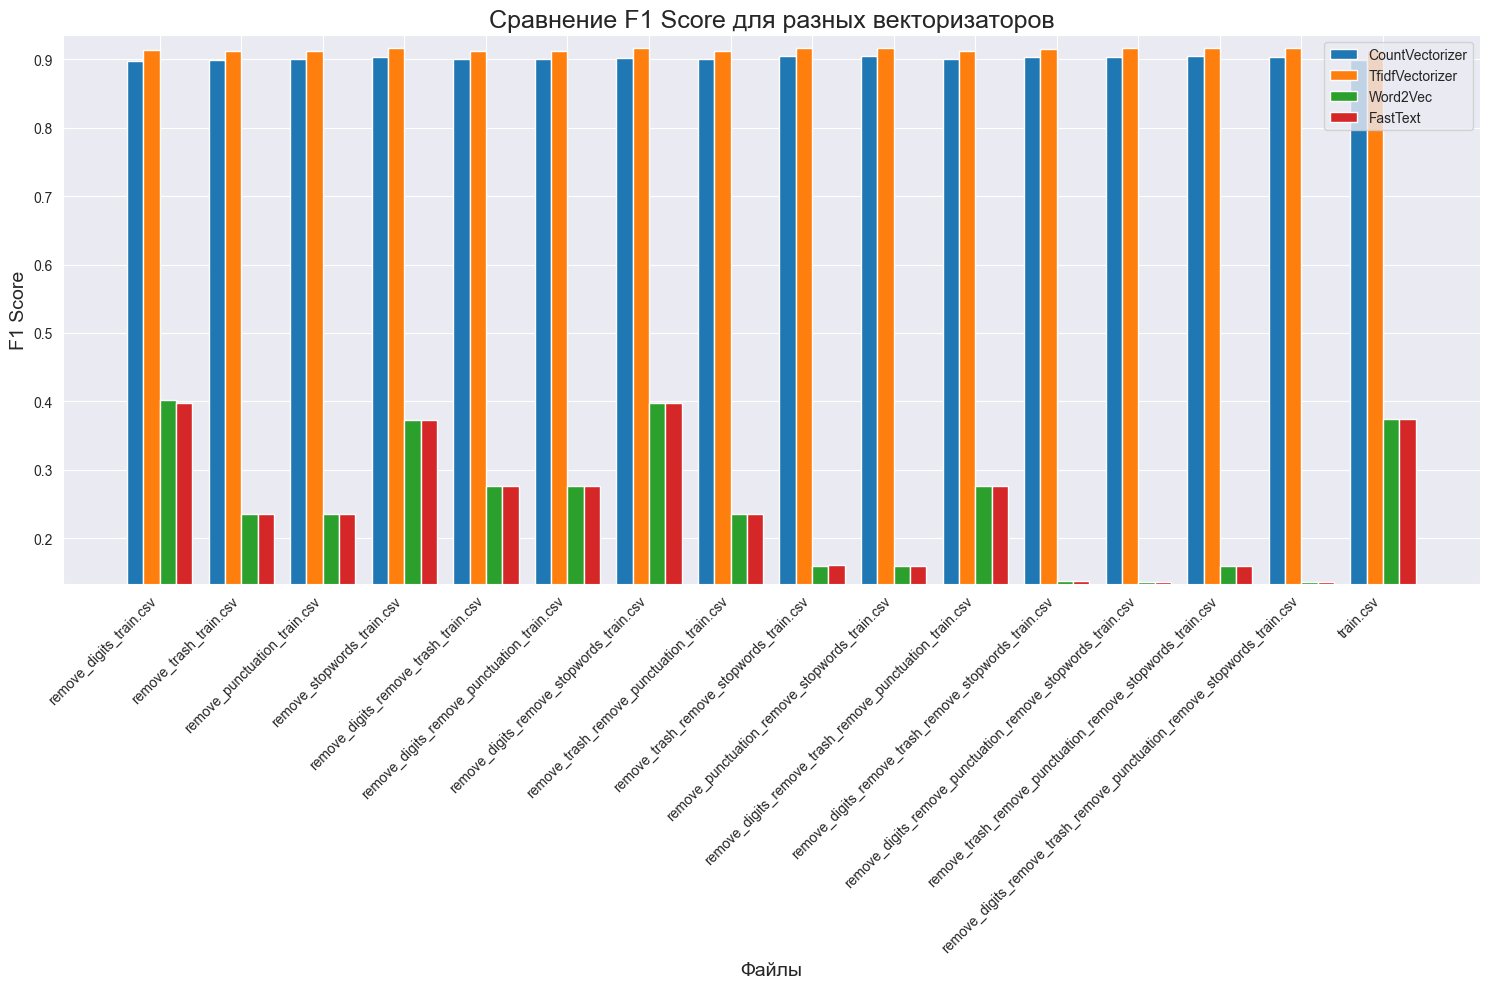

In [71]:
import matplotlib.pyplot as plt

# Создаем фигуру и оси с помощью matplotlib
fig, ax = plt.subplots(figsize=(15, 10))

# Переменные для хранения информации о позициях на оси X
x_labels = []
count_vec_scores = []
tfidf_vec_scores = []
word2vec_scores = []
fasttext_scores = []

# Извлекаем данные и добавляем их в списки
for filename in result['CountVectorizer'].keys():
    x_labels.append(filename)
    count_vec_scores.append(result['CountVectorizer'][filename])
    tfidf_vec_scores.append(result['TfidfVectorizer'][filename])
    word2vec_scores.append(result.get('Word2Vec', {}).get(filename, 0))  # 0 если результатов для Word2Vec нет
    fasttext_scores.append(result.get('FastText', {}).get(filename, 0))  # 0 если результатов для FastText нет

# Создаем массив индексов для оси X
x = range(len(x_labels))

# Размер сдвига для каждого столбца на диаграмме
bar_width = 0.2

# Рисуем столбчатые диаграммы
ax.bar(x, count_vec_scores, width=bar_width, label='CountVectorizer', align='center')
ax.bar([i + bar_width for i in x], tfidf_vec_scores, width=bar_width, label='TfidfVectorizer', align='center')
ax.bar([i + bar_width * 2 for i in x], word2vec_scores, width=bar_width, label='Word2Vec', align='center')
ax.bar([i + bar_width * 3 for i in x], fasttext_scores, width=bar_width, label='FastText', align='center')

# Добавляем названия и метки
ax.set_xlabel('Файлы', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_title('Сравнение F1 Score для разных векторизаторов', fontsize=18)
ax.set_xticks([i + bar_width * 1.5 for i in x])  # Смещаем тики, чтобы они были посередине между группами баров
ax.set_xticklabels(x_labels, rotation=45, ha="right")

# Установим пределы для оси Y, чтобы улучшить визуализацию
all_scores = count_vec_scores + tfidf_vec_scores + word2vec_scores + fasttext_scores
y_min = min(all_scores) * 0.98  # немного ниже минимального значения
y_max = max(all_scores) * 1.02  # немного выше максимального значения
ax.set_ylim(y_min, y_max)

# Добавляем легенду
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()


In [72]:
for vectorizer_name, scores in result.items():
    # Получаем лучший файл и F1 оценку для каждого векторизатора
    best_file = max(scores, key=scores.get)
    best_score = scores[best_file]

    print(f"Лучший F1 Score для {vectorizer_name}: {best_score} (Файл: {best_file})")

Лучший F1 Score для CountVectorizer: 0.9052599728333353 (Файл: remove_trash_remove_stopwords_train.csv)
Лучший F1 Score для TfidfVectorizer: 0.9165554600128112 (Файл: remove_digits_remove_stopwords_train.csv)
Лучший F1 Score для Word2Vec: 0.402562804252402 (Файл: remove_digits_train.csv)
Лучший F1 Score для FastText: 0.3979476072949701 (Файл: remove_digits_train.csv)
Лучший F1 Score для GloVe: 0.3979476072949701 (Файл: remove_digits_train.csv)


In [89]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Сначала скачаем необходимые ресурсы для nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Функция для определения части речи слова для лемматизации
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stemm_and_lemmatize_text(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(stemmer.stem(word), get_wordnet_pos(word))
        for word in tokens
    ]
    return ' '.join(tokens)

def stemm_text(text):
    tokens = word_tokenize(text)
    tokens = [
        stemmer.stem(word)
        for word in tokens
    ]
    return ' '.join(tokens)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(word))
        for word in tokens
    ]
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to C:\Users\Витя
[nltk_data]     Кенг\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Витя
[nltk_data]     Кенг\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Витя Кенг\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [90]:
[X_train, X_test, X_val, y_train, y_test, y_val] = read_and_split("remove_trash_remove_stopwords_train.csv")

variants = ["stemm_and_lemmatize_text", "stemm_text", "lemmatize_text"]

for v in variants:
    # Предобработка данных с использованием одной из функций
    X_train_processed = X_train.apply(eval(v))
    X_val_processed = X_val.apply(eval(v))
    # Векторизация с использованием TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
    X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)

    # Обучение логистической регрессии
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train_tfidf, y_train)

    # Предсказание и вычисление F1 score
    y_val_pred = logistic_regression.predict(X_val_tfidf)
    f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"F1 Score после {v}: {f1}")

F1 Score после stemm_and_lemmatize_text: 0.9171827192684909
F1 Score после stemm_text: 0.9171366036160151
F1 Score после lemmatize_text: 0.9175183031055423


Появилась идея сначал предобработать текст полностью, а потом уже отправить в векторизаторы:

In [77]:
[X_train, X_test, X_val, y_train, y_test, y_val] = read_and_split("remove_digits_remove_stopwords_train.csv")

X_train_processed = X_train.apply(lemmatize_text)
X_test_processed = X_test.apply(lemmatize_text)
X_val_processed = X_val.apply(lemmatize_text)
result = {}
for vectorizer_name in vectorizers:
    if not result.get(vectorizer_name):
        result[vectorizer_name] = {}

    if vectorizer_name in ["CountVectorizer", "TfidfVectorizer"]:
        vectorizer = eval(vectorizer_name)()
        X_train_vec = vectorizer.fit_transform(X_train)
        X_val_vec = vectorizer.transform(X_val)
        X_test_vec = vectorizer.transform(X_test)
    else:
        X_train_tokens = X_train.apply(word_tokenize)
        X_val_tokens = X_val.apply(word_tokenize)
        X_test_tokens = X_test.apply(word_tokenize)
        if vectorizer_name == "Word2Vec":
            X_train_vec = transform_with_word_embedding(X_train_tokens, word2vec_model)
            X_val_vec = transform_with_word_embedding(X_val_tokens, word2vec_model)
            X_test_vec = transform_with_word_embedding(X_test_tokens, word2vec_model)
        elif vectorizer_name == "FastText":
            X_train_vec = transform_with_word_embedding(X_train_tokens, fasttext_model)
            X_val_vec = transform_with_word_embedding(X_val_tokens, fasttext_model)
            X_test_vec = transform_with_word_embedding(X_test_tokens, fasttext_model)


    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train_vec, y_train)
    y_val_pred = log_reg.predict(X_val_vec)
    y_test_pred = log_reg.predict(X_test_vec)

    f1_score_mean = (f1_score(y_val, y_val_pred, average="weighted") +
                     f1_score(y_test, y_test_pred, average="weighted")) / 2
    result[vectorizer_name][filename] = f1_score_mean
print(result)

{'CountVectorizer': {'train.csv': 0.901817322121623}, 'TfidfVectorizer': {'train.csv': 0.9165554600128112}, 'Word2Vec': {'train.csv': 0.3978801695658114}, 'FastText': {'train.csv': 0.39670088069640197}, 'GloVe': {'train.csv': 0.39670088069640197}}


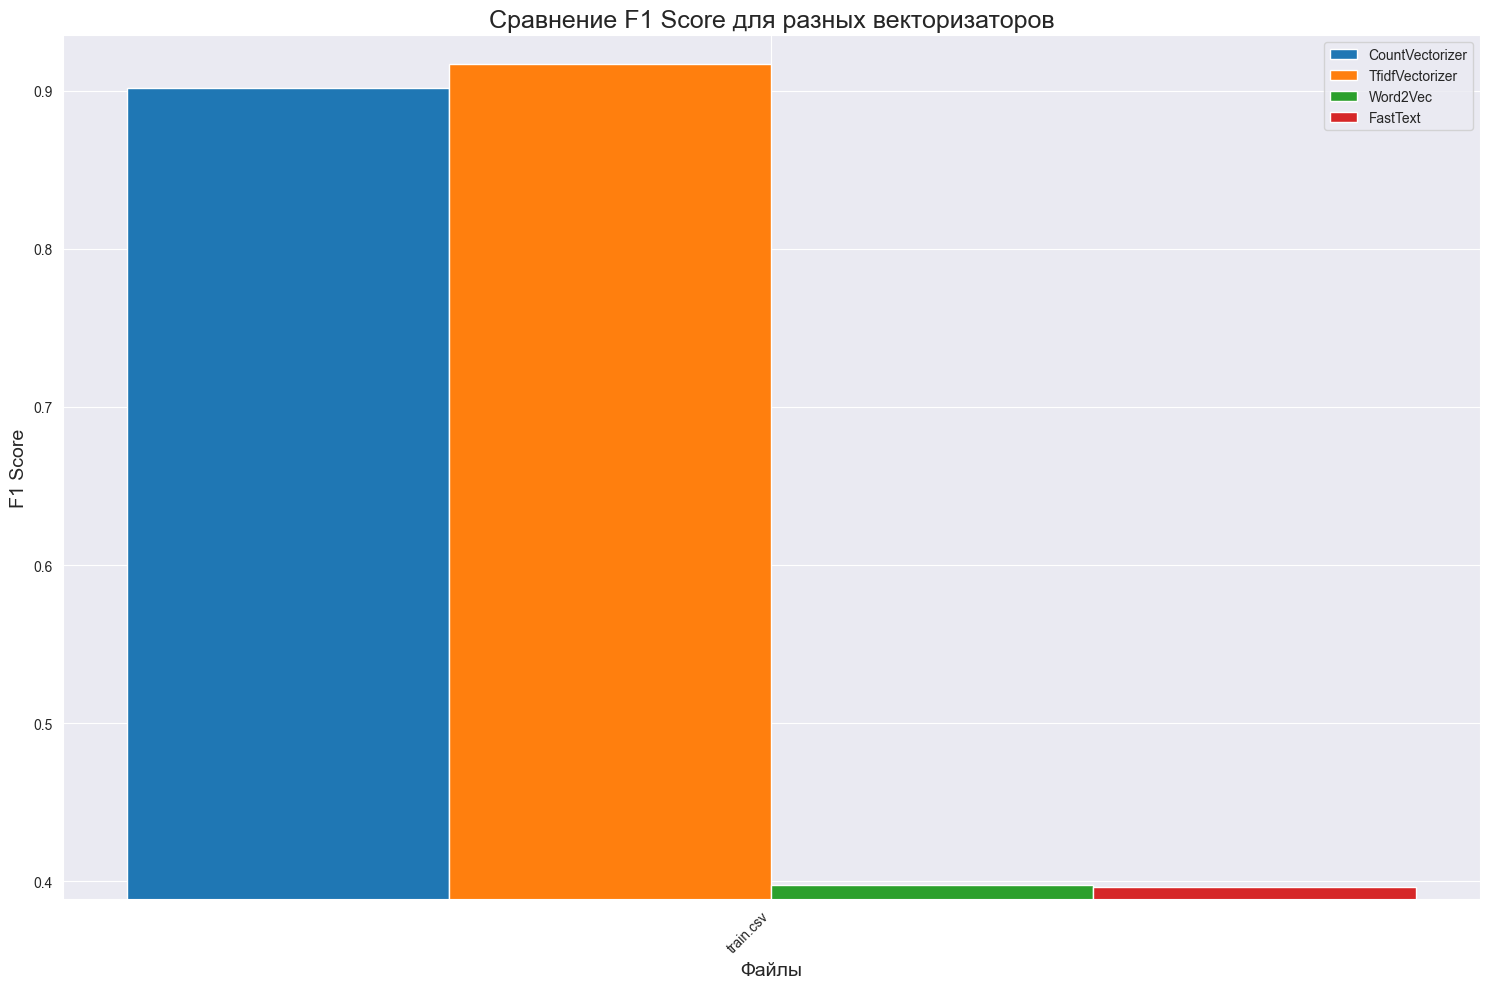

In [79]:

import matplotlib.pyplot as plt

# Создаем фигуру и оси с помощью matplotlib
fig, ax = plt.subplots(figsize=(15, 10))

# Переменные для хранения информации о позициях на оси X
x_labels = []
count_vec_scores = []
tfidf_vec_scores = []
word2vec_scores = []
fasttext_scores = []

# Извлекаем данные и добавляем их в списки
for filename in result['CountVectorizer'].keys():
    x_labels.append(filename)
    count_vec_scores.append(result['CountVectorizer'][filename])
    tfidf_vec_scores.append(result['TfidfVectorizer'][filename])
    word2vec_scores.append(result.get('Word2Vec', {}).get(filename, 0))  # 0 если результатов для Word2Vec нет
    fasttext_scores.append(result.get('FastText', {}).get(filename, 0))  # 0 если результатов для FastText нет

# Создаем массив индексов для оси X
x = range(len(x_labels))

# Размер сдвига для каждого столбца на диаграмме
bar_width = 0.2

# Рисуем столбчатые диаграммы
ax.bar(x, count_vec_scores, width=bar_width, label='CountVectorizer', align='center')
ax.bar([i + bar_width for i in x], tfidf_vec_scores, width=bar_width, label='TfidfVectorizer', align='center')
ax.bar([i + bar_width * 2 for i in x], word2vec_scores, width=bar_width, label='Word2Vec', align='center')
ax.bar([i + bar_width * 3 for i in x], fasttext_scores, width=bar_width, label='FastText', align='center')

# Добавляем названия и метки
ax.set_xlabel('Файлы', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_title('Сравнение F1 Score для разных векторизаторов', fontsize=18)
ax.set_xticks([i + bar_width * 1.5 for i in x])  # Смещаем тики, чтобы они были посередине между группами баров
ax.set_xticklabels(x_labels, rotation=45, ha="right")

# Установим пределы для оси Y, чтобы улучшить визуализацию
all_scores = count_vec_scores + tfidf_vec_scores + word2vec_scores + fasttext_scores
y_min = min(all_scores) * 0.98  # немного ниже минимального значения
y_max = max(all_scores) * 1.02  # немного выше максимального значения
ax.set_ylim(y_min, y_max)

# Добавляем легенду
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()

Всё плохо!

In [82]:
[X_train, X_test, X_val, y_train, y_test, y_val] = read_and_split("remove_digits_remove_stopwords_train.csv")

X_train_processed = X_train.apply(lemmatize_text)
X_test_processed = X_test.apply(lemmatize_text)
X_val_processed = X_val.apply(lemmatize_text)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Инициализация модели случайного леса
rf = RandomForestClassifier(random_state=42)

# Сетка гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_weighted')

# Выполнение поиска
grid_search.fit(X_train_tfidf, y_train)

# Вывод лучших параметров и лучшего F1-меры
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best F1 Score: {grid_search.best_score_}')

# Предсказание на валидационной выборке с лучшей найденной моделью
y_val_pred = grid_search.predict(X_val_tfidf)

# Расчет и вывод F1-меры и полного отчета классификации
print(f'Validation F1 Score: {f1_score(y_val, y_val_pred, average="weighted")}')
print(classification_report(y_val, y_val_pred))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.8834355722455967
Validation F1 Score: 0.8941405032488708
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      4159
           2       0.92      0.98      0.95      4215
           3       0.88      0.86      0.87      4254
           4       0.88      0.86      0.87      4172

    accuracy                           0.89     16800
   macro avg       0.89      0.89      0.89     16800
weighted avg       0.89      0.89      0.89     16800



In [85]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

# Создайте и обучите модель
gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
clf = svm.SVC()
clf.fit(X_train_tfidf, y_train)
gnb = GaussianNB()
gnb.fit(X_train_tfidf.toarray(), y_train)

Validation F1 Score: 0.8413908357362964


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [88]:
for model in ["gb", "gnb", "clf"]:
    result = eval(model).predict((X_val_tfidf.toarray() if model == "gnb" else X_val_tfidf))
    print(f'Validation F1 Score: {f1_score(y_val, result, average="weighted")}')
    result = eval(model).predict((X_test_tfidf.toarray() if model == "gnb" else X_test_tfidf))
    print(f'Validation F1 Score: {f1_score(y_test, result, average="weighted")}')

Validation F1 Score: 0.8413908357362964
Validation F1 Score: 0.8377523961235736
Validation F1 Score: 0.760269412547459
Validation F1 Score: 0.7555779543937968
Validation F1 Score: 0.9223068447045999
Validation F1 Score: 0.9208548480915856
